In [2]:
%matplotlib inline
# Only if you have a high-resolution "retina" display:
%config InlineBackend.figure_format = 'retina'

import numpy
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8))  # Larger figure sizes
plt.rc('image', origin='lower')  # Make image zero on bottom
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] =  16.0

i_units = units.Quantity(1, unit="kW m-2 sr-1 nm-1")

## Getting data and inverting profiles

Note that in data we have $I_{\nu}^{obs}$.

In [4]:
DATA_FILE = 'SST_sunspot_617_2020_08_07.fits' 
data = QTable.read(DATA_FILE)

#calculating inverted porifles
data['intensity_inverted'] = data['intensity'][0] - data['intensity']
data['stokes_v_inverted'] = data['stokes_v'][0] - data['stokes_v']

data['rest_wavelength'] = 617.30 * units.nm #FeI

## Spectral Velocities

In [5]:
sp = data['intensity'][:-1]
sp = sp[0] - sp
wv = data['wavelength'][:-1]
wave0 = 617.30 * units.nm

moment1 = numpy.trapz(wv[:, numpy.newaxis, numpy.newaxis] * sp, wv, axis=0) / numpy.trapz(sp, wv, axis=0)
moment2 = numpy.trapz((wv[:, numpy.newaxis, numpy.newaxis] - moment1)**2 * sp, wv, axis=0) / numpy.trapz(sp, wv, axis=0)
moment2[moment2 < 0] = 0

v_los = (constants.c * (wave0 - moment1) / wave0).to('km/s')
width = (numpy.sqrt(moment2) * constants.c / wave0).to('km/s')

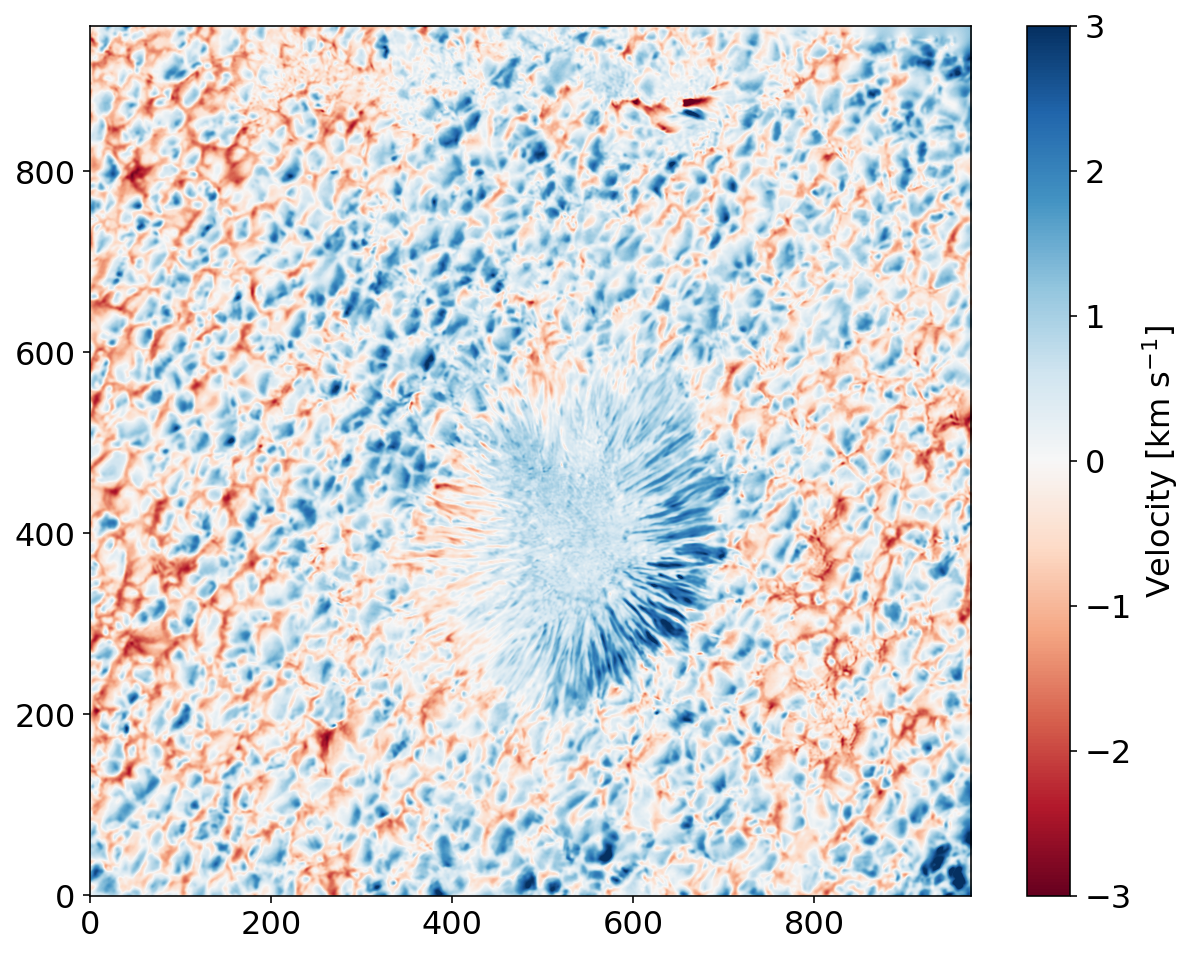

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(v_los.value, cmap='RdBu')
im.set_clim(-3,3)
cbar = fig.colorbar(im)
cbar.set_label(r'Velocity [km s$^{-1}$]')

## Brightness temperatures

Planck function:
\begin{equation} 
   B_\nu(T) = \frac{2h\nu^3}{c^2} 
                  \frac{1}{\mathrm{e}^{h\nu/ kT}-1}
\end{equation}

Inverted Planck function:
\begin{equation}
    \mathrm{e}^{h\nu/ kT}  
    = \frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1
\end{equation}

\begin{equation}
    h\nu/ kT  
    = \ln{\left[\frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1\right]}
\end{equation}

\begin{equation}
    T = \frac{h\nu}{k}
    \left(\ln{\left[\frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1\right]}\right)^{-1}
\end{equation}

Inserting $\left(B_\nu(T_b)\right)^{-1} = I_{\nu}^{obs}$ gives

\begin{equation}
    T_b = \frac{h\nu}{k}
    \left(\ln{\left[\frac{2h\nu^3}{c^2}\left(I_{\nu}^{obs}\right)^{-1}
    + 1\right]}\right)^{-1}
\end{equation}

In [34]:
#adding brightness temperature to dataset
k, h, c = constants.k_B, constants.h, constants.c

nu = data['wavelength'].to(units.Hz, equivalencies=units.spectral())
intensity = data['intensity']

T_b = (h*nu/k * numpy.log(((2*h*nu**3)/(c**2 * intensity.T*units.sr)) + 1)).decompose()

data['brightness_temperature'] = T_b.T

## Plotting brightness temperature for all data

About a factor of 10 wrong.

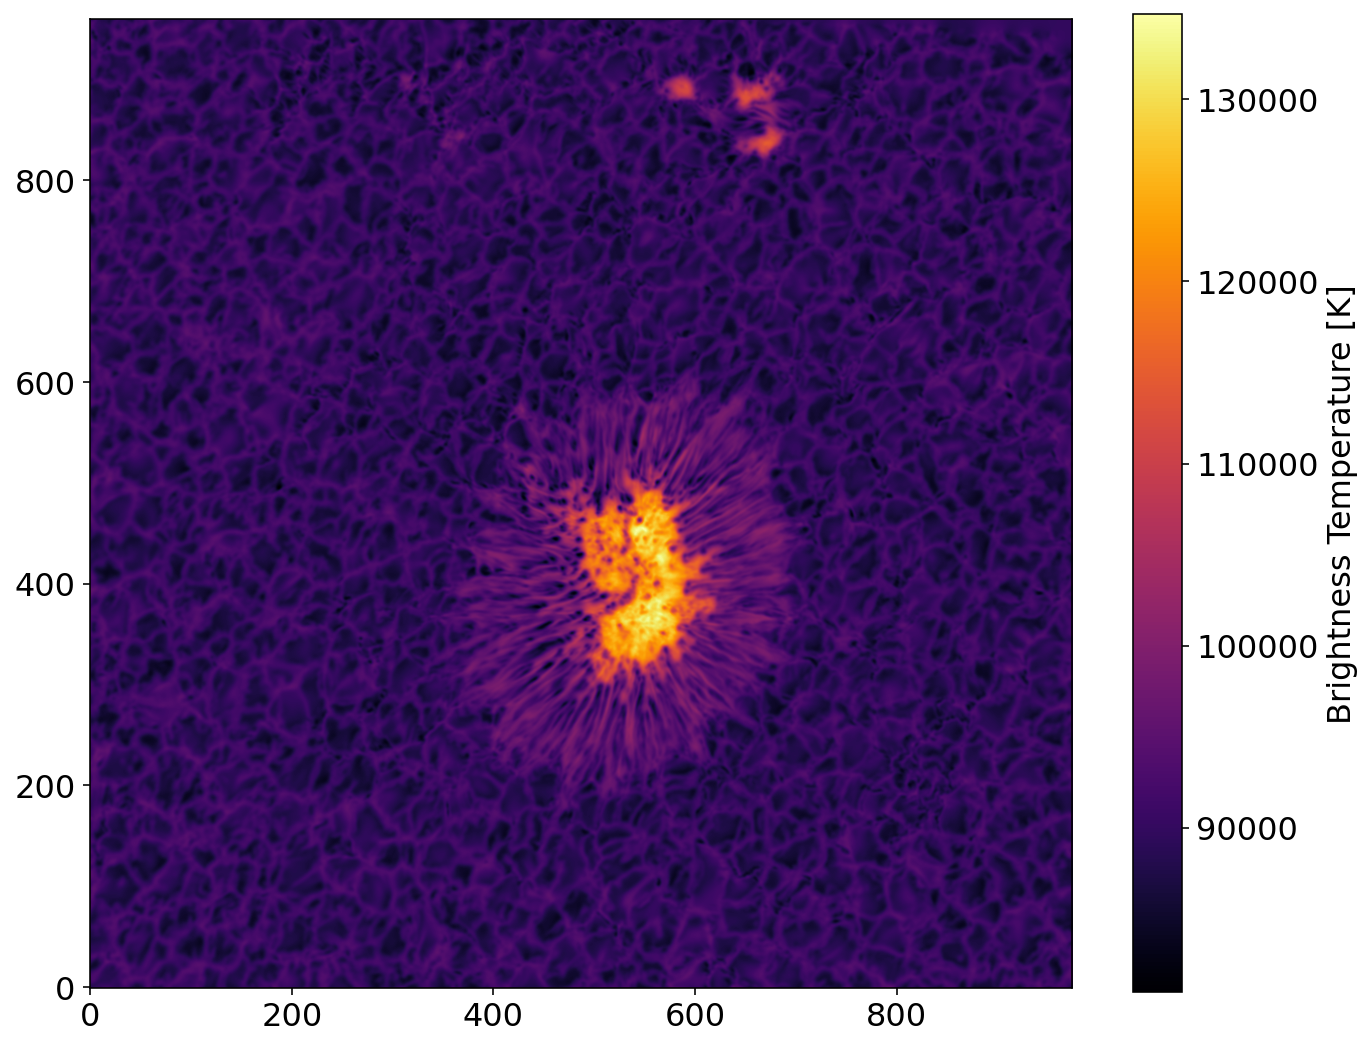

In [35]:
fig, ax = plt.subplots(figsize=(11,9))
im = ax.imshow(data['brightness_temperature'][0].value, cmap='inferno');
cbar = fig.colorbar(im)
cbar.set_label(r'Brightness Temperature [K]')

## Plotting for region same as C img from facebook

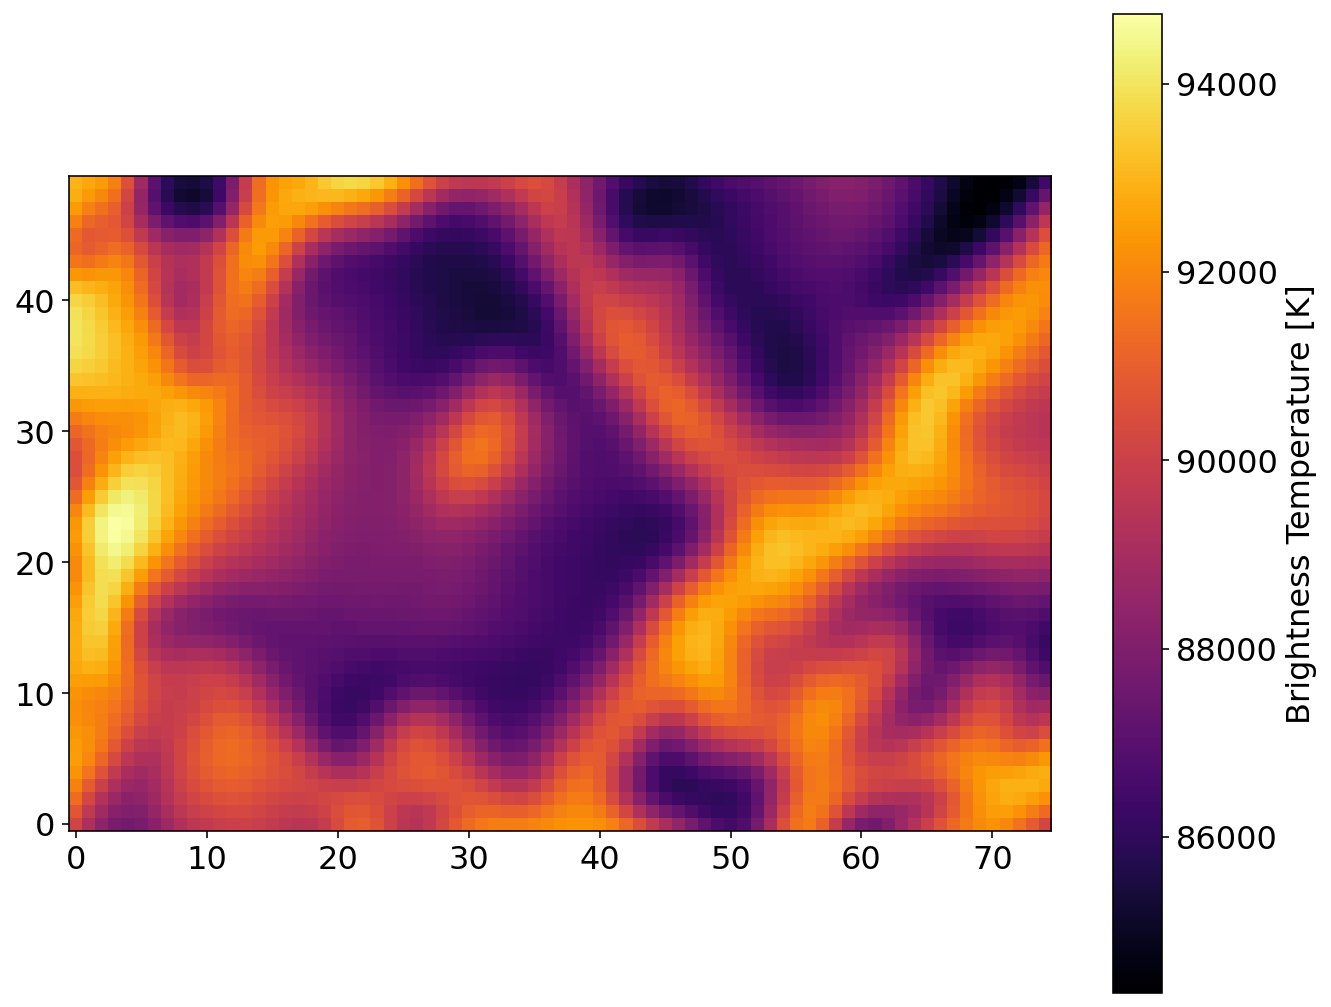

In [36]:
fig, ax = plt.subplots(figsize=(11,9))

im = ax.imshow(data['brightness_temperature'][0, 75:125, 0:75].value, cmap='inferno');
cbar = fig.colorbar(im)
cbar.set_label(r'Brightness Temperature [K]')

## Magnetic field strength

\begin{equation}
    B_\mathrm{los} 
    = -\frac{4 \pi m_e c}{e \bar{g} \lambda_0^2}\frac{\sum_\lambda \frac{\partial I}{\partial \lambda} V_\lambda}{\sum_\lambda\left(\frac{\partial I}{\partial \lambda}\right)^2}
\end{equation}

B ser ut til å være kun en verdi pr punkt fordi man summerer over bølgelengdene. Men det er en massiv feil her fordi $B_{los}$ får unit nm istedetfor Tesla i program under. 

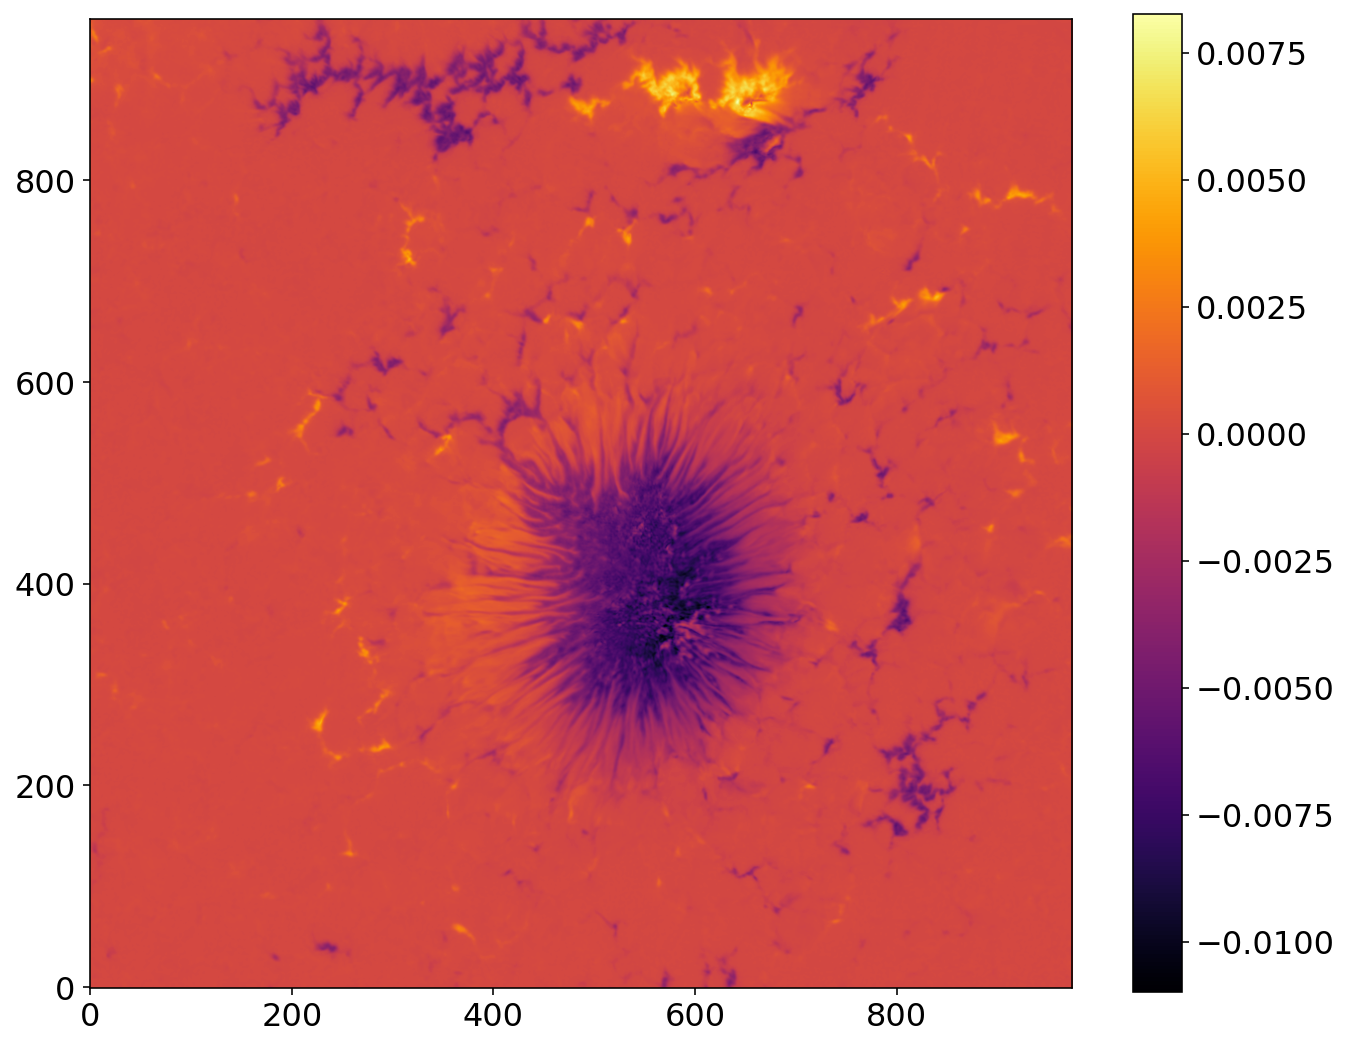

In [91]:
pi = numpy.pi
m_e = constants.m_e
c = constants.c
e = constants.e.emu #MAYBE WRONG WITH THE .emu
g = 2.499 #Lande factor

diff_intensity = numpy.diff(data['intensity'], axis=0)
diff_wl = numpy.diff(data['wavelength'])

dIdlambda = diff_intensity.T/diff_wl

B_los = numpy.sum(dIdlambda.T * data['stokes_v'][0:-1], axis=0)/ numpy.sum(dIdlambda**2, axis=2).T
data['B_los'] = B_los[numpy.newaxis, :, :]

fig, ax = plt.subplots(figsize=(11,9))
im = ax.imshow(data['B_los'][0], cmap='inferno');
cbar = fig.colorbar(im)    

# END

In [17]:



























import numpy as np
# Define the Gaussian function
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y

from scipy.optimize import curve_fit

continuum_intensity = data['intensity'][0, :, :]
intensity_inverted = continuum_intensity - data['intensity']
wl = data['wavelength']


parameters, covariance = curve_fit(Gauss, wl, intensity_inverted.T)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [22]:
def doppler_velocity(observed_wl, rest_wl, c=constants.c):
    delta_wl = rest_wl - observed_wl
    return c * delta_wl/rest_wl 

In [49]:
fe_one_line = 617.334 * units.nm

DATA_FILE = 'SST_sunspot_617_2020_08_07.fits' 
data = QTable.read(DATA_FILE)

#data['doppler_velocity'] = data['intensity']
#print(data)

In [ ]:
data['doppler_velocity']

In [ ]:
"""Work in progress"""
class solar_spot:
    def __init__(self, data):
        self.data = data
        self.stokes_continuum = data['stokes_v'][0, :, :]
        self.intensity

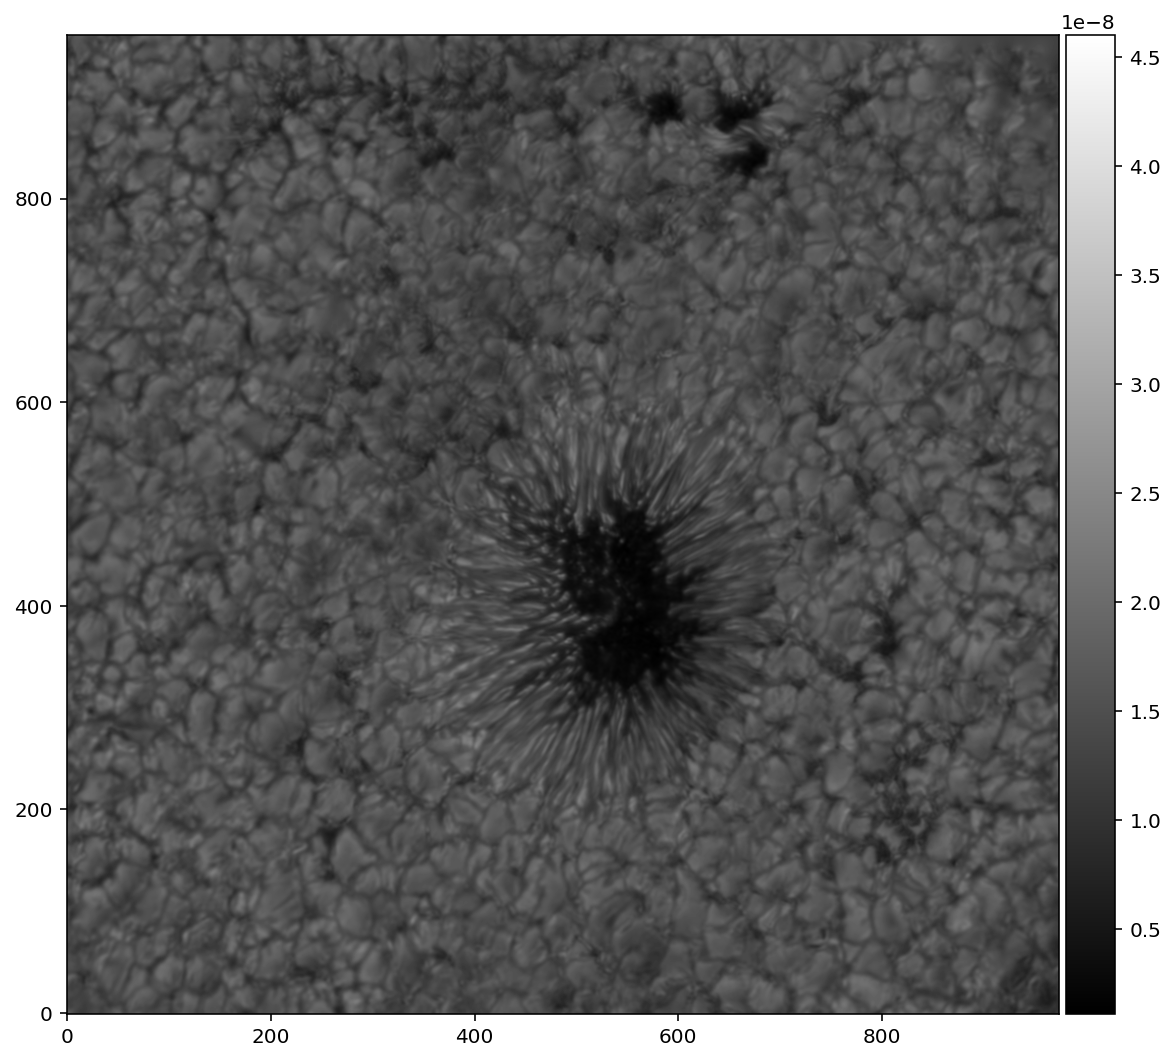

In [64]:

fig, ax = plt.subplots(figsize=(11,9))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(intensity_inverted[6].value, vmax=4.6e-8, cmap="gist_gray")


fig.colorbar(im, cax=cax, orientation='vertical')

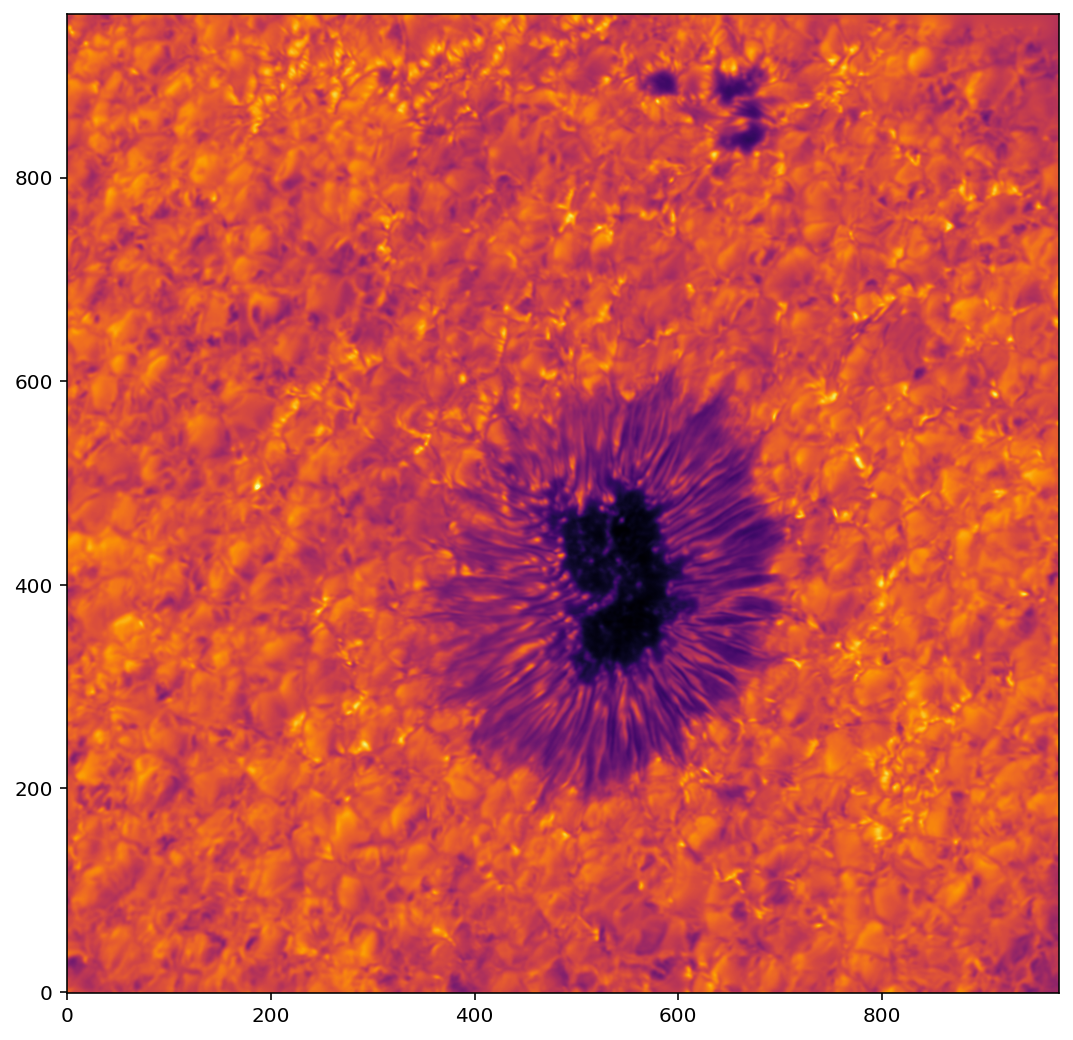

In [45]:

fig, ax = plt.subplots(figsize=(11,9))
ax.imshow(data['intensity'][4].value, vmax=4.6e-8, cmap='inferno');

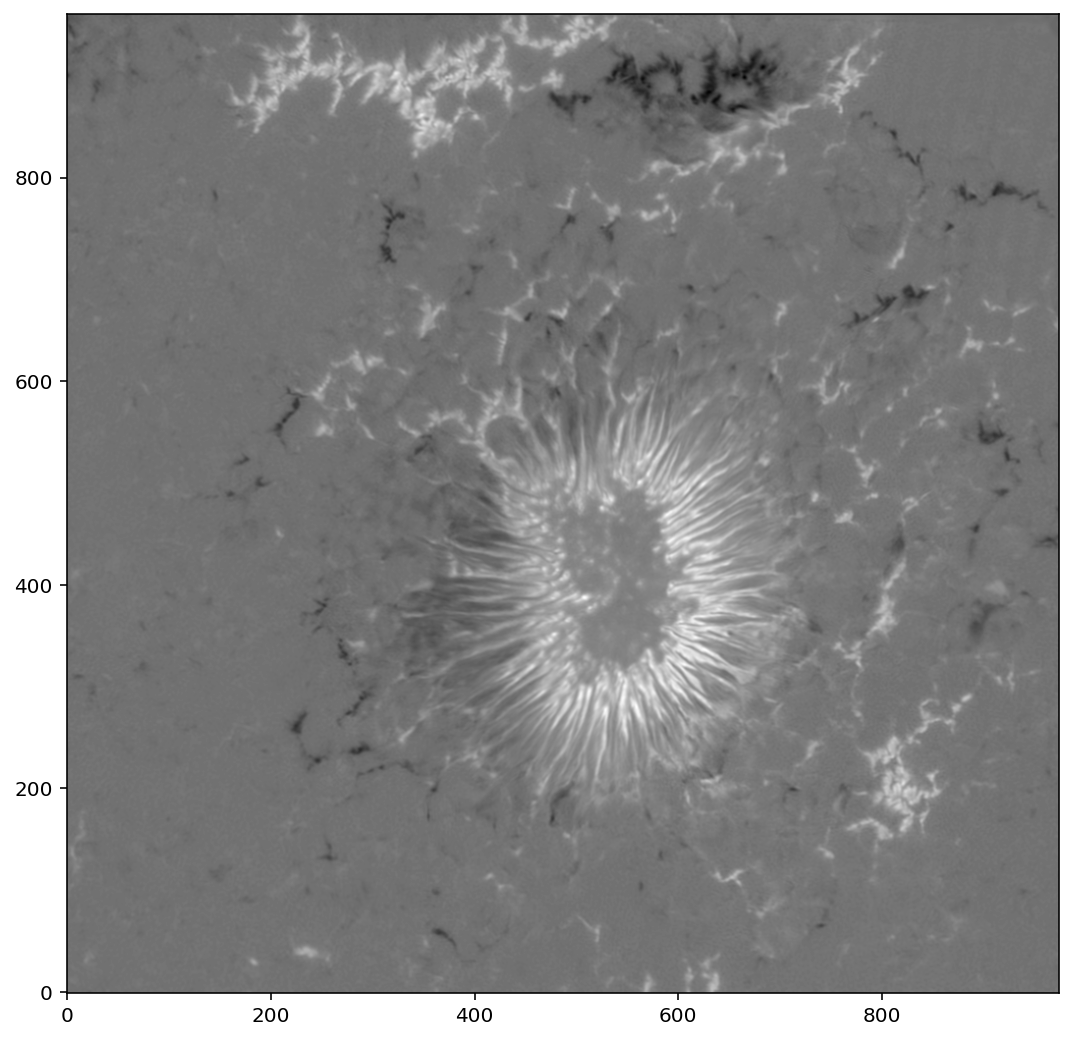

In [8]:
fig, ax = plt.subplots(figsize=(11,9))
ax.imshow(data['stokes_v'][4].value,  cmap='gist_gray');

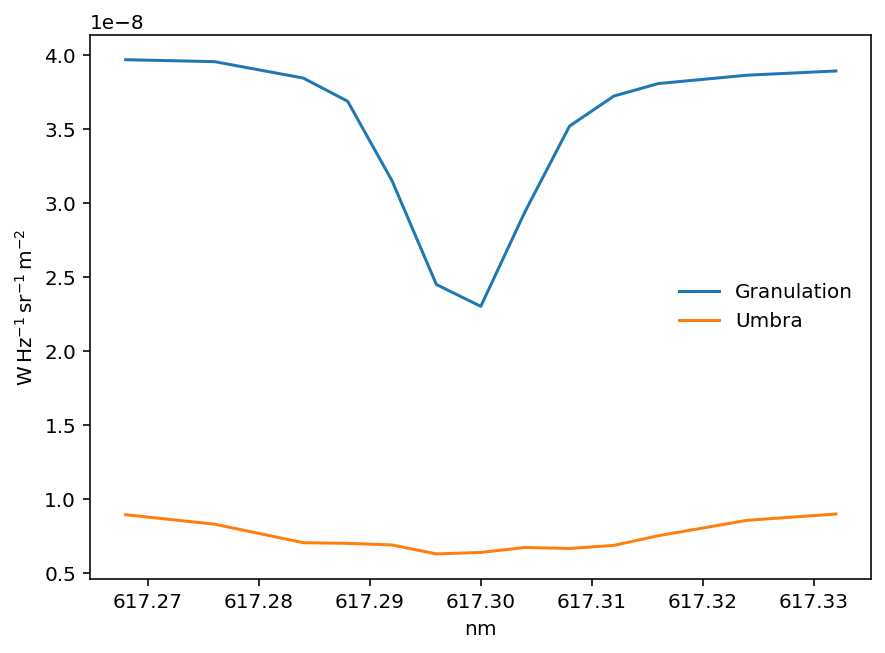

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
wavelength = data['wavelength']

#dette funker sånn her: (x,y) = (200, 200) og : går gjennom intensity
#for alle wavelengths på det punktet
ax.plot(wavelength, data['intensity'][:, 200, 200], label='Granulation')

ax.plot(wavelength, data['intensity'][:, 400, 550], label='Umbra')
ax.legend();

In [13]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,8))
im1 = ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno')
im2 = ax.imshow(data['stokes_v'][4].value,  cmap='gist_gray')

anim = ArtistAnimation(fig, [[im1], [im2]], interval=200, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

Imagine you are one of the pioneers observing sunspots for the first time and know nothing about their properties. Your task is to analyse the SST dataset using the spectral diagnostics listed above. In your essay, you should report your findings to an audience of your peers who are similarly ignorant about sunspots, but knowledgeable about spectral analysis (so you don't need to explain what spectral lines are or what we can learn from them). You should answer the following questions: 
- Using spectral velocities and brightness temperatures, what can you tell about the solar granulation? Which is cooler: the granules or the inter-granular lanes? How are they moving in relation to us? 
- In terms of spectral properties, what sets a sunspot apart from the neigbouring granulation? 
- Do pores share the same spectral properties of sunspots? Are the two connected? 
- Where in a sunspot do you find the largest velocities? And the strongest magnetic fields? 
- How much colder are sunspots than the solar granulation? Why are they dark? 
- How does the size of this sunspot compare with planet Earth? 

This exercise will be graded using the following criteria: 
* [28 points] **Diagnostics**: correctly extract physical quantities from the data. 
* [43 points] **Physical interpretation**: being able to relate the derived quantities to the physics in the solar atmosphere. 
* [24 points] **Presentation**: clear and concise text, appropriate plots and graphics, and connecting them in a coherent way.

Trying to find the line of sight magnetic field strength. Using $V_\lambda$ (Stokes V) and $I_\lambda$

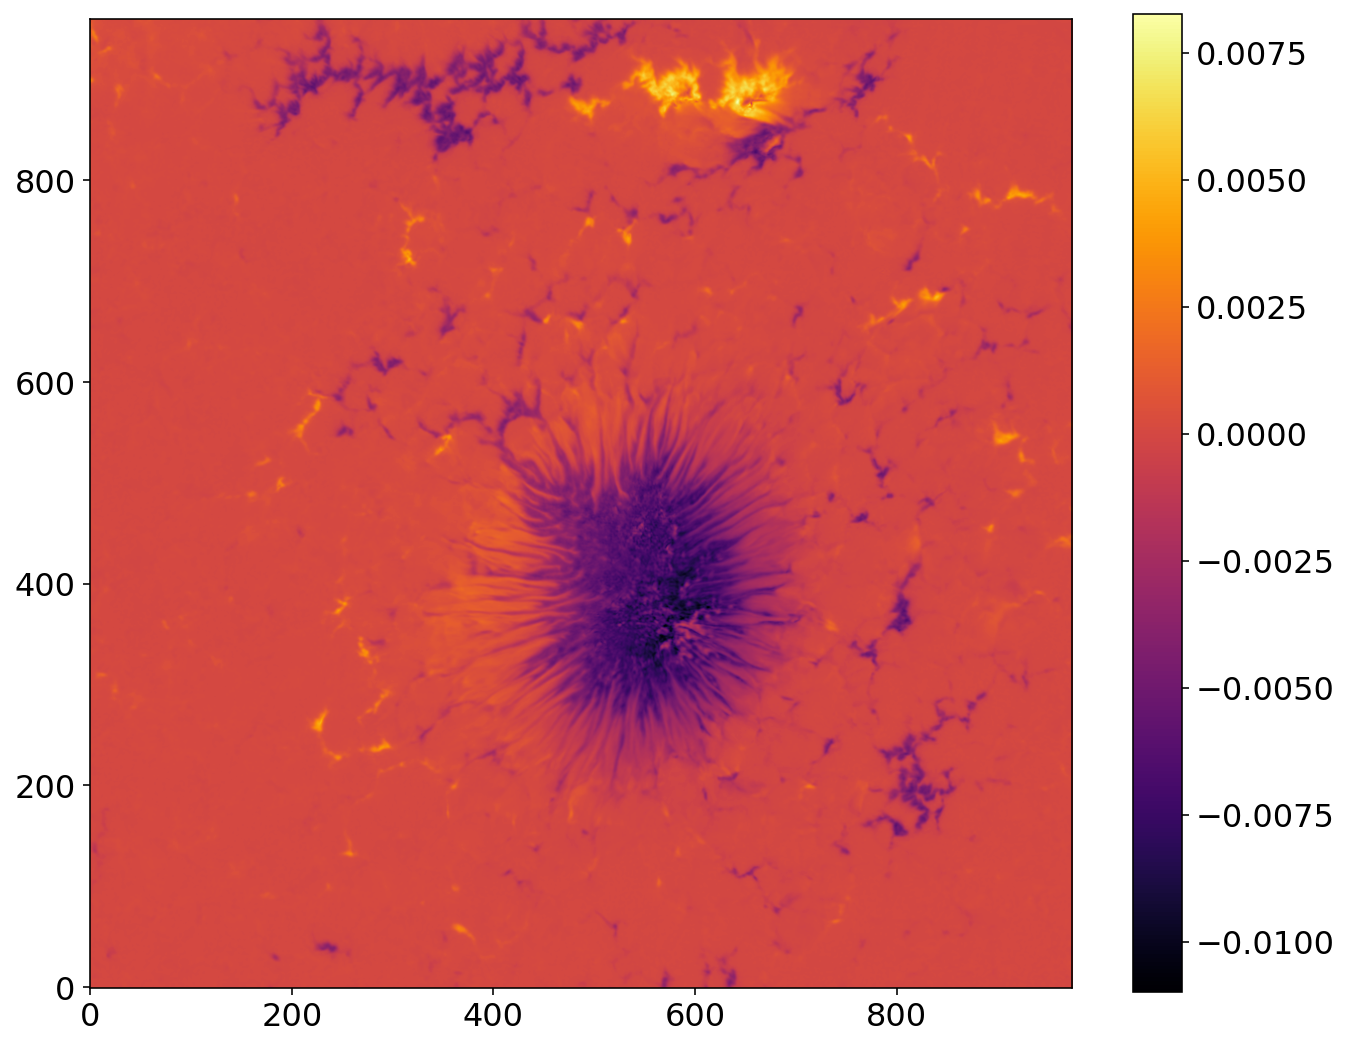

In [87]:
pi = numpy.pi
m_e = constants.m_e
c = constants.c
e = constants.e.emu #MAYBE WRONG WITH THE .emu
g = 2.499 #Lande factor

diff_intensity = numpy.diff(data['intensity'], axis=0)
diff_wl = numpy.diff(data['wavelength'])

dIdlambda = diff_intensity.T/diff_wl

B_los = numpy.sum(dIdlambda.T * data['stokes_v'][0:-1], axis=0)/ numpy.sum(dIdlambda**2, axis=2).T
data['B_los'] = B_los[numpy.newaxis, :, :]

fig, ax = plt.subplots(figsize=(11,9))
im = ax.imshow(data['B_los'][0], cmap='inferno');
cbar = fig.colorbar(im)    

In [ ]:
def B_los(data):
    const = 1 #just some physicals consts, put in later
    - const * 

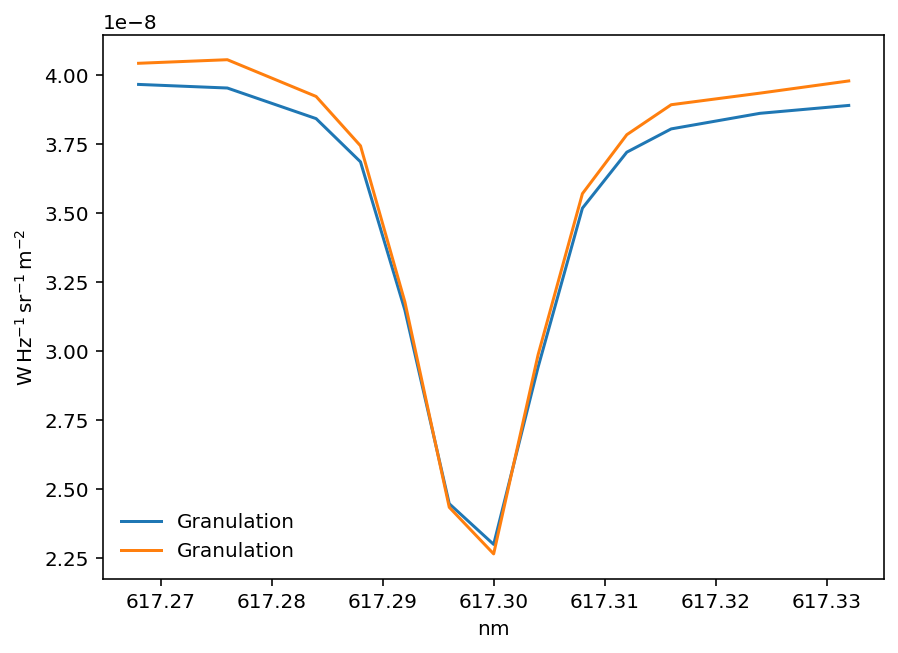

In [70]:
fig, ax = plt.subplots(figsize=(7, 5))
wavelength = data['wavelength']
ax.plot(wavelength, data['intensity'][:, 200, 200], label='Granulation')
ax.plot(wavelength, data['intensity'][:, 205, 200], label='Granulation')
#ax.plot(wavelength, data['intensity'][:, 400, 550], label='Umbra')
ax.legend();

**Follow regular rapport structure.**

Inter-granular lanes or something.

Temp, velocity, line width (from magnetic field)
What is different between sunspots, surrounding, and pores

polarization neg/pos depending on magnetic field direction.

Remember for earlier projects: If you look at wavelengths more in the dip it is from another part of the atmosphere.

Stokes V:
white = positive mag field
black = negative mag field
There is difference in the umbra and granulation wavelength broadening due to this

a = 3, 4
Should centre velocity around zero: valn=-a, vmax=a


IMRAD